# Simple CCZ4 Finite Volume code
 
A solver of the Einstein equations that uses the original ExaHyPE FORTRAN kernels.

In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.startswith("output")]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use and we have to give it a name. There are a few more options that we omit here, i.e. we use the defaults.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "ccz4"], "ccz4" )

## Configuring the solver

Our first step is to use a Finite Volumes solver. I write down all the unknowns first. I'll use this dictionary later to access variables symbolically. For the time being, I just define this map and then count the number of unknowns. This total count is something I really need to configure my solver.

In [4]:
unknowns = {
  "G":6,
  "K":6,
  "theta":1,
  "Z":3,
  "lapse":1,
  "shift":3,
  "b":3,
  "dLapse":3,
  "dxShift":3,
  "dyShift":3,
  "dzShift":3,
  "dxG":6,
  "dyG":6,
  "dzG":6,
  "traceK":1,
  "phi":1,
  "P":3,
  "K0":1,
  "rho":1,
  "u":3,
  "p":1
}

number_of_unknowns = 0
for i in unknowns:
  number_of_unknowns += unknowns[i]
print( "number of unknowns=", number_of_unknowns )

number of unknowns= 64


The solver itself is a simple Finite Volume solver with fixed time stepping. I use the enclave solver variant which is a solver nuance that is particuarly good on large shared memory architectures. Our PDE is expressed solely in a nonconservative formulation. I therefore can switch the flux term off.

In [5]:
patch_size          = 6
auxiliary_variables = 0
time_step_size      = 0.01
max_h               = 0.4
min_h               = 0.4

my_solver = exahype2.solvers.fv.GenericRusanovFixedTimeStepSizeWithEnclaves(
  "CCZ4", patch_size, number_of_unknowns, auxiliary_variables, min_h, max_h, time_step_size
)


project.add_solver(my_solver)

I next inject homogeneous Neumann boundary conditions:

In [6]:
import exahype2.sympy

pde = exahype2.sympy.PDE(unknowns=number_of_unknowns,auxiliary_variables=0,dimensions=3)

my_solver.set_implementation(
  boundary_conditions=exahype2.solvers.fv.PDETerms.User_Defined_Implementation,
  flux=exahype2.solvers.fv.PDETerms.None_Implementation,
  ncp=exahype2.solvers.fv.PDETerms.User_Defined_Implementation
)   


## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [26]:
build_mode = peano4.output.CompileMode.Asserts
#build_mode = peano4.output.CompileMode.Release

dimensions = 3
end_time = 4.0
snapshots = time_step_size*20
    
project.set_global_simulation_parameters(
  dimensions,               # dimensions
  [-0.5, -0.5, -0.5],  [1.0, 1.0, 1.0],
  end_time,                 # end time
  0.0, snapshots,   # snapshots
  [True,True,True]          # Periodic BC
)

## Generate a Peano 4 project

This is exactly the same as for Euler: We ask the ExaHyPE 2 front-end to give us a Peano project.

In [27]:
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is g++
CXXFLAG -g is already in list of flags. Ignored as force attribute is not set
CXXFLAG -O2 is already in list of flags. Ignored as force attribute is not set
CXXFLAG -fopenmp is already in list of flags. Ignored as force attribute is not set
used Fortran compiler is gfortran
FCFLAGS -g is already in list of flags. Ignored as force attribute is not set
FCFLAGS -O2 is already in list of flags. Ignored as force attribute is not set


A "big" difference to Euler is that we now have some external Fortran files. Usually, we take the default settings when we invoke the Fortran compiler. Default is the stuff given to us by Peano's configure. There's however the opportunity to add further flags manually. I use this here as the astro code requies some bespoke defines. Also, I need the -cpp flag. Otherwise the preprocessor macros are not taken into account properly and my Intel compiler terminates.
- The option "-DGLMROT" can be added to enable curl cleaning, however this requires additional variables. Be sure to add these before enabling this option.
- With GNU, I have used 
<pre>
./configure  FC="gfortran" CXX="g++" LDFLAGS="-L/opt/vtk/lib64 -L/opt/intel/tbb/lib/intel64/gcc4.8 -ltbb_debug -lpthread" CXXFLAGS="-I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include"   --enable-exahype --enable-loadbalancing-toolbox --with-multithreading=omp
</pre>
for this one on my system.
- With Intel, I used
<pre>
./configure FC="ifort" CXX="icpc" LDFLAGS="-L/opt/vtk/lib64 -L/opt/intel/tbb/lib/intel64/gcc4.8 -ltbb_debug -lpthread -lifcore" CXXFLAGS="-I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include"   --enable-exahype --enable-loadbalancing-toolbox --with-multithreading=omp
</pre>

In [28]:
peano4_project.output.makefile.add_Fortran_flag( "-DCCZ4EINSTEIN -DDim3" )

# This is for GNU
peano4_project.output.makefile.add_Fortran_flag( "-lstdc++ -fdefault-real-8 -fdefault-double-8 -cpp -std=legacy -ffree-line-length-512 -fPIC" )
peano4_project.output.makefile.add_linker_flag( "-lstdc++ -fPIC -lgfortran" )

# This might work for Intel (not tested)
#peano4_project.output.makefile.add_Fortran_flag( "-r8 -cpp -auto -qopenmp-simd -O2" )
#peano4_project.output.makefile.add_linker_flag( "-lstdc++ -fPIC" )
# you might need -lifcore

peano4_project.output.makefile.add_Fortran_module( "MainVariables.f90" )

peano4_project.output.makefile.add_Fortran_files( 
  ["PDE.f90 ", "EinsteinConstraints.f90 ",
    "Metric.f90 ", "C2P-FOCCZ4.f90 "] 
)

FCFLAGS -DCCZ4EINSTEIN -DDim3 is already in list of flags. Ignored as force attribute is not set
FCFLAGS -lstdc++ -fdefault-real-8 -fdefault-double-8 -cpp -std=legacy -ffree-line-length-512 -fPIC is already in list of flags. Ignored as force attribute is not set
Fortran module file 
MainVariables.f90
is already in module file list. Did not add it once more. You can overwrite 
this default behaviour via the force attribute in add_Fortran_module(). If 
you create multiple Peano 4 makefiles in a row (as you change parameters, e.g.)
then this message can typically be ignored.



# Prepare the CCZ4 solver

This means invoking the right Fortran routines at the right time. First, we have to tell the Fortran lib which scenario we want to work with. For this, we create a symbol identifier in Python and export it into the C++ code.
We then write a standard constructor of the CCZ4 solver which pipes the constant through through the Fortran code. Seems to be quite some overhead, but it allows us to switch the scenario through Python. 

In [29]:
#peano4_project.constants.export_string( "Scenario", "CCZ4GaugeWave")
peano4_project.constants.export_string( "Scenario", "gaugewave-c++" )

# Create C++ code

We finally generate the C++ code:

In [30]:
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated ccz4-main.cpp
write ./Makefile
write ././AbstractCCZ4.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.h)
write ././AbstractCCZ4.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/CCZ4Q.h (generated from template /home/tobias/git/Peano/python/peano4/datamodel/PatchToDoubleArray.template.h)
write ./celldata/CCZ4Q.cpp (generated from template /home/tobias/git/Peano/pyth

The build below should fail when you first call it in an empty directory. After all, we have promised to deliver an ncp implementation, but there is none.

In [25]:
parallel_builds = 1   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
#peano4_project.build( make_clean_first = False, number_of_parallel_builds = parallel_builds )
!make -j4


g++ -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o AbstractCCZ4.o AbstractCCZ4.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/SolverRepository.o observers/SolverRepository.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o celldata/CCZ4Q.o celldata/CCZ4Q.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o celldata/CCZ4CellSemaphoreLabel.o celldata/CCZ4CellSemaphoreLabel.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o facedata/CCZ4Q.o facedata/CCZ4Q.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o facedata/CCZ4QNew.o facedata/CCZ4QNew.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o facedata/Label.o facedata/Label.cpp
g++ -std=c++0x -g -O2 -DPeanoD

## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [13]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
run of application was not successful: [Errno 2] No such file or directory: 'mpirun'
invocation: ['mpirun', '-n', '1', './peano4']


False

We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [14]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
file output.txt is invalid as number of time steps equals zero


In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

/home/tobias/git/Peano/python/exahype2/postprocessing/overview_plots.py:22: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)


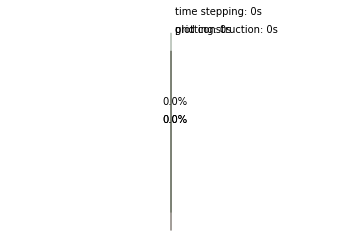

In [15]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

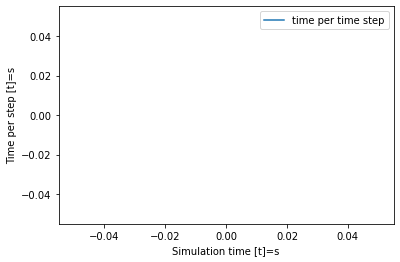

In [16]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Inspecting output files via Paraview

We first do an ls on our directory and search for the root .peano-patch-file. I then convert this file manually into vtu which I can load into Paraview. This works if Peano is configured with vtk support. If you don't have vtk support in there, then you might want to load the data directly into Paraview through Peano's Paraview plug-in.

In [17]:
!ls

AbstractCCZ4.cpp  ccz4-main.cpp		   exahype.log-filter  observers
AbstractCCZ4.h	  ccz4-main.h		   facedata	       output.txt
AbstractCCZ4.o	  ccz4-main.o		   MainVariables.f90   PDE.f90
C2P-FOCCZ4.f90	  CCZ4.o		   mainvariables.mod   PDE.h
C2P-FOCCZ4.o	  celldata		   MainVariables.o     PDE.o
CCZ4.cpp	  Constants.h		   Makefile
CCZ4.h		  EinsteinConstraints.f90  Metric.f90
CCZ4.ipynb	  EinsteinConstraints.o    Metric.o


# Visualisation

We have different ways how to visualise the outcome. If you have VTK support in your configure call, then Peano has built a vtk command line converter. 


Alternatively, start up Paraview

<pre>
export PYTHONPATH=../../../python
paraview
</pre>

and use Peano's visualisation routines through the Paraview Python terminal:


<pre>
import peano4.visualisation

output_files = "solution-CCZ4.peano-patch-file"
visualiser = peano4.visualisation.Visualiser( output_files )
visualiser.append_filter(peano4.visualisation.ExtractFineGridFilter())
visualiser.display()
</pre>

With !ls I see how many snapshots we've written:

In [18]:
!ls

AbstractCCZ4.cpp  ccz4-main.cpp		   exahype.log-filter  observers
AbstractCCZ4.h	  ccz4-main.h		   facedata	       output.txt
AbstractCCZ4.o	  ccz4-main.o		   MainVariables.f90   PDE.f90
C2P-FOCCZ4.f90	  CCZ4.o		   mainvariables.mod   PDE.h
C2P-FOCCZ4.o	  celldata		   MainVariables.o     PDE.o
CCZ4.cpp	  Constants.h		   Makefile
CCZ4.h		  EinsteinConstraints.f90  Metric.f90
CCZ4.ipynb	  EinsteinConstraints.o    Metric.o


The Paraview script class then allows me to switch to one of these snapshots:

<pre>
visualiser.select_dataset(9)
</pre>

Alternatively, I can ask the visualiser to convert the whole data series into a video and then open this output file. Invoke the call below and then load the resulting pvd file manually:

<pre>
visualiser.write_vtu_time_series()
</pre>

In [19]:
import peano4.visualisation
convert = peano4.visualisation.Convert( "solution-CCZ4", True )
convert.set_visualisation_tools_path( "../../../src/visualisation" )
convert.extract_fine_grid()
convert.convert_to_vtk()

ModuleNotFoundError: No module named 'paraview'